## Prétraitement des données

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd


def extract_data_brut(file_path,output_csv_path):
    '''
    extraire les textes et leurs parits à partir des corpus d'apprentissage bruts
    et les conserver dans un fichier csv pour chaque langue
    '''
    
    tree = ET.parse(file_path)
    root = tree.getroot()

    data = []
    for doc in root.findall('.//doc'):
        # obtenir tous les paragraphes du texte et les joindre en un seul
        text_elements = doc.findall('.//texte//p')
        texte = ' '.join([elem.text.strip() for elem in text_elements if elem.text])
        partis = [parti.get('valeur') for parti in doc.findall('.//PARTI')]
        for parti in partis:
            data.append({'texte': texte, 'parti': parti})

    df = pd.DataFrame(data)

    return df.to_csv(output_csv_path, index=False, encoding='utf-8')

def extract_and_combine_text_label(xml_file_path, label_file_path, output_csv_path):
    '''
    extraire les textes tests dans les fichiers xml de et leurs labels des fichiers textes 
    et les combiner dans un seul fichier csv pour chaque langue
    '''   
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    test_data = []
    for doc in root.findall('.//doc'):
        # obtenir tous les paragraphes du texte et les joindre en un seul
        text_elements = doc.findall('.//texte//p')
        texte = ' '.join([elem.text.strip() for elem in text_elements if elem.text])
        test_data.append({'texte': texte})

    texte_df = pd.DataFrame(test_data)

    # lecture des labels à partir du fichier texte et les combiner avec les textes dans un même dataframe
    labels_df = pd.read_csv(label_file_path, sep='\t', header=None, names=['id', 'label'])
    labels_df.set_index('id', inplace=True)

    # ajouter une colonne id pour pouvoir joindre les deux dataframes
    texte_df['id'] = range(1, len(texte_df) + 1)
    texte_df.set_index('id', inplace=True)

    # joindre les deux dataframes en utilisant l'index id comme clé de jointure 
    combined_df = texte_df.join(labels_df, how='left')
    
    combined_df.to_csv(output_csv_path, index=False)

In [3]:
import nltk
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# installer les packages nltk nécessaires pour la préparation des données 
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text, lang):
    '''
    prétraiter le texte en appliquant les étapes suivantes:
    - convertir le texte en minuscules
    - supprimer les nombres
    - supprimer les apostrophes
    - supprimer les mots de longueur inférieure ou égale à 2
    - supprimer les stopwords et la ponctuation
    '''
    # assurer que le texte est de type str
    if not isinstance(text, str):
        text = str(text)  # convertir en str

    # charger les stopwords selon la langue
    if lang == 'en':
        stop_words = set(stopwords.words('english'))
    elif lang == 'fr':
        stop_words = set(stopwords.words('french'))
    elif lang == 'it':
        stop_words = set(stopwords.words('italian'))

    # enlever les symboles ennuyeux et les nombres 
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r"['’‘]", ' ', text)  
    text = re.sub(r'\b\w{1,2}\b', '', text)  

    words = word_tokenize(text.lower())

    # enlever les stopwords et la ponctuation
    words = [word for word in words if word not in stop_words and word not in string.punctuation]

    cleaned_text = ' '.join(words)
    return cleaned_text

def preprocess_csv(csv_path, lang,output_csv_path):
    '''
    lecture du fichier csv contenant les textes et leurs labels
    et prétraitement des textes
    '''
    # lire le fichier csv sauvegardé précédemment
    df = pd.read_csv(csv_path)

    # appliquer la fonction de prétraitement sur la colonne texte
    df['texte'] = df['texte'].apply(lambda x: preprocess_text(x, lang))

    df.to_csv(output_csv_path, index=False, encoding='utf-8')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liuyingzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/liuyingzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vectoriser les textes en utilisant la méthode TF-IDF

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

def tfidfVectorize(CSV_train, CSV_test):
    '''
    vectoriser les textes en utilisant la méthode TF-IDF
    '''
    train_df = pd.read_csv(CSV_train)
    test_df = pd.read_csv(CSV_test)
    train_df.dropna(subset=['texte'], inplace=True)
    test_df.dropna(subset=['texte'], inplace=True)

    # initialiser le vectorizer avec les paramètres désirés
    vectorizer = TfidfVectorizer(
        ngram_range=(1,3),
        max_df=0.5,
        use_idf=True,
        sublinear_tf=True,
        max_features=10000
    )

    # vectoriser les textes d'entraînement et de test 
    print("Vectorizing train data...")
    X_train = vectorizer.fit_transform(tqdm(train_df['texte']))

    print("Vectorizing test data...")
    X_test = vectorizer.transform(tqdm(test_df['texte']))
    # récupérer les labels correspondants

    y_train = train_df['parti'].astype(str)
    y_test = test_df['parti'].astype(str)

    return X_train, X_test, y_train, y_test

## Modèle DecisionTree

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Vectorizing train data...


100%|███████████████████████████████████| 19365/19365 [00:07<00:00, 2685.63it/s]


Vectorizing test data...


100%|███████████████████████████████████| 12913/12913 [00:04<00:00, 3198.01it/s]


Accuracy: 0.7353829474173313
Kappa Score: 0.6464296270191205
Classification Report:
               precision    recall  f1-score   support

        ELDR       0.72      0.66      0.69      1339
     GUE-NGL       0.75      0.74      0.74      1792
      PPE-DE       0.76      0.78      0.77      4571
         PSE       0.73      0.73      0.73      3626
   Verts-ALE       0.67      0.68      0.68      1585

    accuracy                           0.74     12913
   macro avg       0.73      0.72      0.72     12913
weighted avg       0.74      0.74      0.74     12913



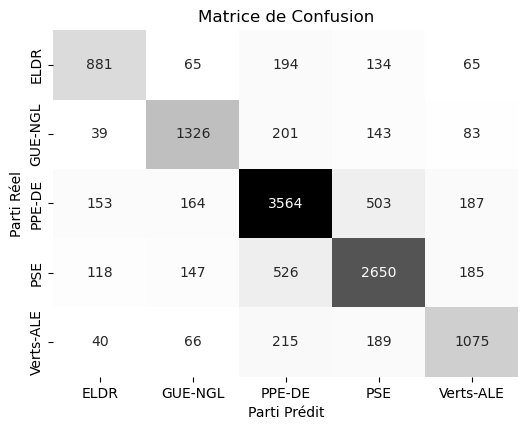

In [1]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tf_idf import tfidfVectorize
from sklearn.tree import DecisionTreeClassifier

def evaluate(X_train, X_test, y_train, y_test, model_name, model):
    '''
    Évaluer les performances du modèle choisi
    en calculant l'accuracy, le kappa et la matrice de confusion
    '''
    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédire les labels sur les données de test
    y_pred = model.predict(X_test)

    return y_test, y_pred

def print_scores(y_test, y_pred):
    '''
    Afficher les scores d'évaluation du modèle choisi
    '''
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Kappa Score:", kappa)
    print("Classification Report:\n", report)


def plot_confusion_matrix(y_test, y_pred, model_name):
    '''
    Sauvegarder la visualisation de la matrice de confusion du modèle choisi
    '''
    # obtenir les labels uniques
    unique_labels = sorted(set(y_test) | set(y_pred))

    # générer la matrice de confusion en spécifiant les labels
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)
    # utiliser seaborn pour afficher la matrice de confusion sous forme de heatmap
    plt.figure(figsize=(6, 4.5))
    sns.heatmap(conf_matrix, annot_kws={"size": 10}, annot=True, fmt='d', cmap='Greys', cbar=False,
                xticklabels=unique_labels, yticklabels=unique_labels)

    plt.xlabel('Parti Prédit')
    plt.ylabel('Parti Réel')
    plt.title('Matrice de Confusion')

    # sauvegarder la figure dans le dossier result avec le nom du modèle
    plt.savefig(f'../result/Confusion_Matrix_{model_name}.png', format='png', dpi=300)
    
    plt.show()


if __name__ == "__main__":
    # Charger les données d'entraînement et de test
    CSV_train = '../data/texte_cleaned/train_text_cleaned_fr.csv'  
    CSV_test = '../data/texte_cleaned/test_text_cleaned_fr.csv'

    X_train, X_test, y_train, y_test = tfidfVectorize(CSV_train, CSV_test)

    # Créer le modèle de l'arbre de décision
    from sklearn.tree import DecisionTreeClassifier
    modele = DecisionTreeClassifier()

    # Évaluer le modèle et obtenir les résultats de prédiction
    y_test, y_pred = evaluate(X_train, X_test, y_train, y_test, 'DecisionTree', modele)

    # Imprimer les scores
    print_scores(y_test, y_pred)

    # Dessiner et afficher la matrice de confusion
    plot_confusion_matrix(y_test, y_pred, 'DecisionTree')


## Modèle LightGBM

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb


def evaluate(X_train, X_test, y_train, y_test, model):
    '''
    Évaluer les performances du modèle choisi
    en calculant l'accuracy, le kappa et la matrice de confusion
    '''
    # Encodage des étiquettes cibles à l'aide de LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train_encoded)

    # Prédire les labels sur les données de test
    y_pred_encoded = []
    batch_size = 1000  # Ajustez cette valeur en fonction de la mémoire disponible
    for i in range(0, len(X_test), batch_size):
        batch_pred = model.predict(X_test[i:i + batch_size])
        y_pred_encoded.extend(batch_pred)

    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculer les scores d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Afficher les scores d'évaluation
    print("Précision:", accuracy)
    print("Score Kappa:", kappa)
    print("Rapport de classification:\n", report)

    # Générer et afficher la matrice de confusion
    plot_confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(y_test, y_pred):
    '''
    Générer et afficher la matrice de confusion
    '''
    unique_labels = sorted(set(y_test) | set(y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 4.5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de Confusion')
    plt.show()

if __name__ == "__main__":
    # Charger les données d'entraînement et de test
    CSV_train = '../data/texte_cleaned/train_text_cleaned_fr.csv'
    CSV_test = '../data/texte_cleaned/test_text_cleaned_fr.csv'

    X_train, X_test, y_train, y_test = tfidfVectorize(CSV_train, CSV_test)

    # Utiliser le modèle LightGBM avec des paramètres ajustés
    model = lgb.LGBMClassifier(num_leaves=31, min_data_in_leaf=20)  # Ajustez ces paramètres en fonction de vos besoins

    # Évaluer et afficher les performances du modèle
    evaluate(X_train, X_test, y_train, y_test, model)


/Users/liuyingzi/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Vectorizing train data...


100%|███████████████████████████████████| 19365/19365 [00:07<00:00, 2732.14it/s]


Vectorizing test data...


100%|███████████████████████████████████| 12913/12913 [00:03<00:00, 3265.69it/s]


## Modèle XGBoost

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb  # Importer XGBoost


def evaluate(X_train, X_test, y_train, y_test, model_name, model):
    '''
    Évaluer les performances du modèle choisi
    en calculant l'accuracy, le kappa et la matrice de confusion.
    '''
    # Encodage des étiquettes cibles à l'aide de LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)  # Ajustement à l'aide des étiquettes de l'ensemble d'apprentissage
    
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train_encoded)

    # Prédire les labels sur les données de test
    y_pred_encoded = model.predict(X_test)

    # Convertir les étiquettes encodées en étiquettes originales
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculer les scores d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Afficher les scores d'évaluation
    print("Précision (Accuracy):", accuracy)
    print("Score Kappa:", kappa)
    print("Rapport de Classification:\n", report)

    # Générer et sauvegarder la matrice de confusion
    plot_confusion_matrix(y_test, y_pred, model_name)

def plot_confusion_matrix(y_test, y_pred, model_name):
    '''
    Sauvegarder la visualisation de la matrice de confusion du modèle choisi.
    '''
    # Obtenir les labels uniques
    unique_labels = sorted(set(y_test) | set(y_pred))

    # Générer la matrice de confusion en spécifiant les labels
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

    # Utiliser seaborn pour afficher la matrice de confusion sous forme de heatmap
    plt.figure(figsize=(6, 4.5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', 
                xticklabels=unique_labels, yticklabels=unique_labels)

    plt.xlabel('Label Prédit')
    plt.ylabel('Label Réel')
    plt.title('Matrice de Confusion pour ' + model_name)

    # Sauvegarder la figure dans le dossier result avec le nom du modèle
    plt.savefig(f'../result/Confusion_Matrix_{model_name}.png', format='png', dpi=300)
    
    plt.show()

if __name__ == "__main__":
    # Charger les données d'entraînement et de test
    CSV_train = '../data/texte_cleaned/train_text_cleaned_fr.csv'
    CSV_test = '../data/texte_cleaned/test_text_cleaned_fr.csv'

    X_train, X_test, y_train, y_test = tfidfVectorize(CSV_train, CSV_test)

    # Utiliser le modèle XGBoost
    model = xgb.XGBClassifier()  # Utiliser le modèle XGBoost avec des paramètres par défaut

    # Évaluer et afficher les performances du modèle
    evaluate(X_train, X_test, y_train, y_test, 'XGBoost', model)


Vectorizing train data...


100%|███████████████████████████████████| 19365/19365 [00:07<00:00, 2733.79it/s]


Vectorizing test data...


100%|███████████████████████████████████| 12913/12913 [00:04<00:00, 3140.46it/s]
